# $$
\begin{cases}
\Delta u =f \\
u \Big |_{\Gamma} = 0
\end{cases}
 \implies I(u) = \frac{1}{2}\iint_D\left[u_x^2 + u_y^2 \right]dxdy + 2\iint_Dfudxdy$$

# Replace the function $u$ with its interploation

# $$u(x,y) = \sum_{i, j}u_{ij}\varphi_{i, j}(x,y)$$

# The necessary condition of stationary point for the functional is
# $$\frac{\partial I}{\partial u} = 0 \implies \frac{\partial}{\partial u_{kl}}I \left(\sum_{i, j}u_{ij}\varphi_{i, j}(x,y)\right) = 0$$ 

### $$ \frac{\partial}{\partial u_{kl}} \left\{\frac{1}{2} \iint_D\left[\left(\sum_{ij}u_{ij}\varphi_{x, ij}(x,y)\right)^2 + \left(\sum_{ij}u_{ij}\varphi_{y, ij}(x,y)\right)^2 \right]dxdy + 2\iint_D\sum_{ij}u_{ij}\varphi_{ij}(x,y)dxdy\right\} = 0$$

# $$\left(\sum_{ij}u_{ij}\varphi_{x, ij}(x,y)\right)^2 = u_{kl}^2\varphi_{x, kl}^2(x,y) + 2u_{kl}\varphi_{x, kl}(x,y)[\dots] + [\dots]^2$$

# $$\left(\sum_{ij}u_{ij}\varphi_{y, ij}(x,y)\right)^2 = u_{kl}^2\varphi_{y, kl}^2(x,y) + 2u_{kl}\varphi_{x, kl}(x,y)[\dots] + [\dots]^2$$

#### $$\frac{\partial}{\partial u_{kl}}I \left(\sum_{i, j}u_{ij}\varphi_{i, j}(x,y)\right)= \iint_D \left[2u_{kl}\varphi_{x, kl}^2(x,y) + 2u_{kl}\varphi_{x, kl}(x,y)[\dots] + 2u_{kl}\varphi_{y, kl}^2(x,y) + 2u_{kl}\varphi_{y, kl}(x,y)[\dots] + 2f_{kl}u_{kl}\varphi_{kl}(x,y)\right]dxdy$$

# $$\frac{\partial}{\partial u_{kl}}I \left(\sum_{i, j}u_{ij}\varphi_{i, j}(x,y)\right)= 8u_{k,l} - 2u_{k, l-1} - u_{k, l+1} - 2u_{k-1,l} - 2u_{k+1,l} = 0$$

In [1]:
import torch
import numpy
from tqdm import tqdm
import matplotlib.pyplot as plt

# Example
# $$
\begin{cases}
\Delta u = 2 \\
u \Big |_{\Gamma} = 0
\end{cases}, (x, y) \in \left[-\frac{\pi}{2},+\frac{\pi}{2}\right]\times\left[-\frac{\pi}{2},+\frac{\pi}{2}\right]
$$

In [18]:
def f(x, y):
    return 2*torch.ones_like(x)

# Number of points per coordinate

In [19]:
n_points = 15

# Construct the necessary matrices

In [20]:
grid = torch.linspace(-torch.pi, torch.pi, n_points)
grid_x, grid_y = torch.meshgrid(grid, grid, indexing="ij")
grid_z = f(grid_x, grid_y)
h_1=h_2=grid[1]-grid[0]
b = -grid_z.reshape(-1)
matrix = torch.zeros(n_points**2, n_points**2)

In [21]:
for i in range(n_points**2):
    idx = numpy.unravel_index(i, (n_points, n_points))
    #These are Dirichlet boundary conditions 
    
    if True:
        if idx[0] == 0:
            matrix[i] *= 0
            matrix[i, i] = 1
            b[i] = 0
            continue
        if idx[0] == n_points - 1:
            matrix[i] *= 0
            matrix[i, i] = 1
            b[i] = 0
            continue
        if idx[1] == 0:
            matrix[i] *= 0
            matrix[i, i] = 1
            b[i] = 0
            continue       
        if idx[1] == n_points - 1:
            matrix[i] *= 0
            matrix[i, i] = 1
            b[i] = 0
            continue
    matrix[i, i] = 8
    if i + 1 < n_points**2:
            matrix[i, i+1] = -2
    if i - 1 > 0:
            matrix[i, i-1] = -2
    if i + n_points + 1 < n_points**2:
            matrix[i, i+n_points] = -2
    if i - n_points > 0:
            matrix[i, i-n_points] = -2

# Solve the system of linear equations

In [22]:
u = torch.linalg.solve(matrix, b)
u = u.reshape(n_points, n_points)

# Basis function (pyramidal function)

In [23]:
def phi(X, Y, h1, h2, i, j, n_x, n_y):
    tx = torch.linspace(X.min(), X.max(), n_x)
    ty = torch.linspace(Y.min(), Y.max(), n_y)
    xx, yy = torch.meshgrid(tx, ty, indexing="ij")
    xm = xx.min()
    ym = yy.min()
    xx = xx - ym
    yy = yy - ym
    tmp = torch.zeros(xx.shape)
    S1 = (i <= xx/h1) & (xx/h1 <= i + 1) & (j <= yy/h2) & (yy/h2 <= j + 1) & (yy/h2 - j >= xx/h1 - i)
    tmp[S1] = (j + 1 - yy/h2)[S1]
    S2 = (i - 1 <= xx/h1) & (xx/h1 <= i) & (j <= yy/h2) & (yy/h2 <= j + 1) & (yy/h2 - j <= 1 + xx/h1 - i)
    tmp[S2] = (1 + xx/h1 - yy/h2 - i + j)[S2]
    S3 = (i - 1 <= xx/h1) & (xx/h1 <= i) & (j - 1 <= yy/h2) & (yy/h2 <= j) & (yy/h2 - j >= xx/h1 - i)
    tmp[S3] = (1 + xx/h1 - i)[S3]
    S4 = (i - 1 <= xx/h1) & (xx/h1 <= i) & (j - 1 <= yy/h2) & (yy/h2 <= j) & (yy/h2 - j <= xx/h1 - i)
    tmp[S4] = (1 + yy/h2 - j)[S4]
    S5 = (i <= xx/h1) & (xx/h1 <= i + 1) & (j - 1 <= yy/h2) & (yy/h2 <= j) & (yy/h2 - j >= xx/h1 - i - 1)
    tmp[S5] = (1 - xx/h1 + yy/h2 + i - j)[S5]
    S6 = (i <= xx/h1) & (xx/h1 <= i + 1) & (j <= yy/h2) & (yy/h2 <= j + 1) & (yy/h2 - j <= xx/h1 - i)
    tmp[S6] = (1 - xx/h1 + i)[S6]
    return tmp

# Sum up all the basis functions

In [24]:
t = torch.linspace(grid[0], grid[-1], 100)
xx, yy, = torch.meshgrid(t, t, indexing="ij")
zz = torch.zeros_like(xx)
for i in range(n_points):
    for j in range(n_points):
        zz += phi(t, t, h_1, h_2, i, j, 100, 100)*u[i][j]

# Visualisation

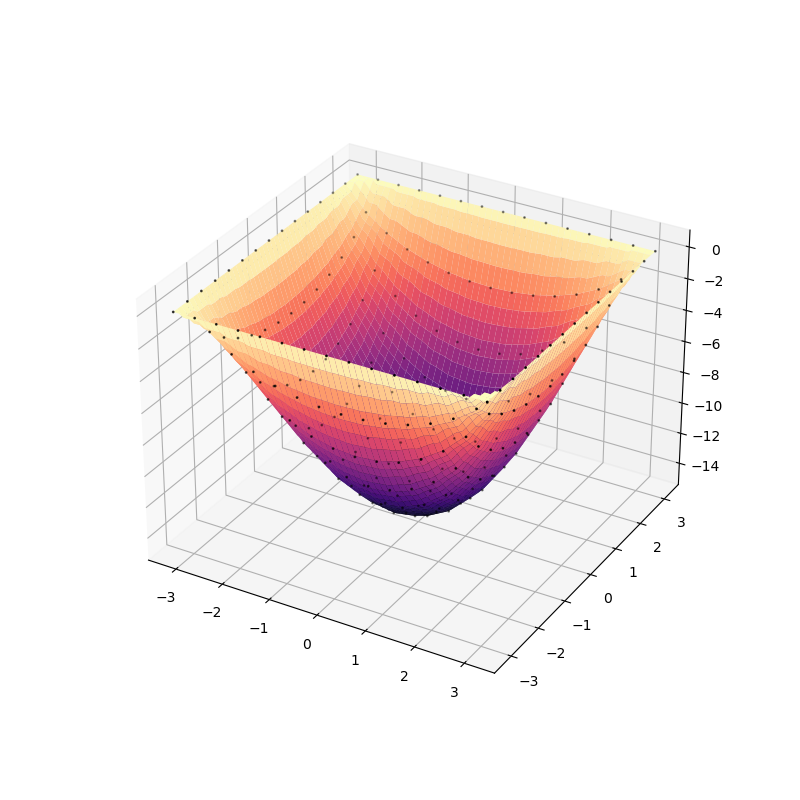

In [25]:
%matplotlib widget
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, zz, cmap="magma")
ax.scatter(grid_x, grid_y, u, color="black", s=1)
plt.show()